<a href="https://colab.research.google.com/github/lhayana/openimages_notation_errors-dog_pics/blob/main/openimages_notation_errors_dog_pics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução

Inicialmente, minha ideia era detectar os erros no open images, do Google. Até que me dei conta que não trabalho na openAI e não conseguiria baixar 9 milhões de imagens no meu SSD de 128GB. Então resolvi ser menos ambiciosa e **detectar os erros apenas em imagens de cachorro** desse dataset, usando como *non-dogs* outros animais fofos que poderiam ser confundidos com cachorro.

Esse projeto, portanto, foca na identificação de possíveis erros de rotulagem em uma base de 1000 imagens originalmente classificadas como 'Cachorro', **obtidas do Open Images V6**. Para auxiliar nessa detecção, foi utilizado um conjunto de dados de contraste composto por 1000 imagens de 'Não-Cães' (uma mistura de Raposas, Ursos e Gatos também do Open Images). O processo metodológico envolveu, primeiramente, a extração de características visuais (features) de todas as 2000 imagens por meio do modelo Vision Transformer (ViT) google/vit-base-patch16-224-in21k. Em seguida, um modelo classificador LogisticRegression foi treinado com essas features usando validação cruzada para gerar probabilidades Out-of-Sample (OOS), refletindo a confiança do modelo em classificar cada imagem da base dogs_images como 'Cão' ou 'Não-Cão'. A análise subsequente dessas probabilidades, particularmente a inspeção visual das imagens de 'Cachorro' com menor confiança P(Dog) atribuída pelo modelo OOS, foi a principal ferramenta para identificar imagens que, apesar do rótulo original, não pareciam ser cães.



# Setup

Instalação e importação das bibliotecas necessárias

In [ ]:
pip install fiftyone

In [ ]:
pip install cleanlab

In [ ]:
# Desinstalar a versão atual de numpy (2.2.5)
!pip uninstall numpy -y

!pip install numpy==1.25.2

# Instalar/Atualizar SciPy para garantir compatibilidade com NumPy 1.26.4
!pip install scipy --upgrade

# Instalar/Atualizar FiftyOne para garantir compatibilidade
!pip install fiftyone --upgrade

In [4]:
import fiftyone as fo
import fiftyone.zoo as foz
import os
import numpy as np
import joblib
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm
import cleanlab

In [15]:
import pandas as pd
from cleanlab import Datalab

# Baixando as imagens

### De cachorros

In [ ]:
# Criando diretório para salvar as imagens
output_dir = "dogs_images"
os.makedirs(output_dir, exist_ok=True)

print("Baixando o dataset Open Images V6...")

# Baixando imagens de cachorro do dataset Open Images
# Definindo o dataset a ser baixado com as configurações específicas
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["detections"],
    classes=["Dog"],
    max_samples=1000,  # Apenas 1000 imagens
    dataset_name="dogs_dataset"
)

print(f"Dataset carregado com {len(dataset)} imagens")

# Exportando as imagens para o diretório
print("Exportando imagens para o diretório...")
dataset.export(
    export_dir=output_dir,
    dataset_type=fo.types.ImageDirectory,
    copy_files=True
)

print(f"Download concluído. Diretório: '{output_dir}'")

# Verificando algumas estatísticas do dataset
print("\nInformações sobre o dataset:")
print(dataset.stats())

# Informações sobre os arquivos baixados
print(f"\nTotal de imagens baixadas: {len(os.listdir(output_dir))}")

### De não-cachorros

In [6]:
# Verificando quais classes relacionadas a canídeos estão disponíveis no Open Images
print("Verificando classes disponíveis relacionadas a canídeos...")
available_classes = foz.load_zoo_dataset_info("open-images-v6").classes
canine_classes = [c for c in available_classes if c.lower() in ["wolf", "coyote", "fox", "jackal", "dingo", "wild dog"]]

print(f"Classes caninas disponíveis: {canine_classes}")

Verificando classes disponíveis relacionadas a canídeos...
Classes caninas disponíveis: ['Fox']


In [7]:
# Importando bibliotecas
import fiftyone as fo
import fiftyone.zoo as foz
import os

# Definindo o diretório para salvar as imagens
output_dir = "similar_animals_images"
os.makedirs(output_dir, exist_ok=True)

print("Verificando classes disponíveis no Open Images...")
available_classes = foz.load_zoo_dataset_info("open-images-v6").classes

# Vamos baixar Fox, Bear e Cat
animal_classes = ["Fox", "Bear", "Cat"]
print(f"Classes de animais que serão baixadas: {animal_classes}")

# Primeiro, vamos baixar todas as raposas disponíveis
print("\n1. Baixando TODAS as imagens de raposas (Fox) disponíveis...")
fox_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["detections"],
    classes=["Fox"],
    max_samples=1000,  # Tentativa de pegar todas as raposas disponíveis
    dataset_name="fox_dataset"
)

print(f"Imagens de raposas carregadas: {len(fox_dataset)}")

# Contando os objetos de raposa
fox_count = 0
for sample in fox_dataset:
    detections = sample.ground_truth.detections
    fox_detections = [d for d in detections if d.label == "Fox"]
    fox_count += len(fox_detections)

print(f"Total de objetos 'Fox' detectados: {fox_count}")

# Em seguida, vamos baixar ursos
print("\n2. Baixando imagens de ursos (Bear)...")
bear_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["detections"],
    classes=["Bear"],
    max_samples=300,  # Um número razoável de imagens de ursos
    dataset_name="bear_dataset"
)

print(f"Imagens de ursos carregadas: {len(bear_dataset)}")

# Contando objetos de urso
bear_count = 0
for sample in bear_dataset:
    detections = sample.ground_truth.detections
    bear_detections = [d for d in detections if d.label == "Bear"]
    bear_count += len(bear_detections)

print(f"Total de objetos 'Bear' detectados: {bear_count}")

# Calculando quantas imagens de gatos precisamos para chegar a 1000 no total
cats_needed = max(0, 1000 - len(fox_dataset) - len(bear_dataset))
print(f"\n3. Baixando {cats_needed} imagens de gatos (Cat) para completar o total...")

if cats_needed > 0:
    cat_dataset = foz.load_zoo_dataset(
        "open-images-v6",
        split="train",
        label_types=["detections"],
        classes=["Cat"],
        max_samples=cats_needed,
        dataset_name="cat_dataset"
    )

    print(f"Imagens de gatos carregadas: {len(cat_dataset)}")

    # Contando objetos de gato
    cat_count = 0
    for sample in cat_dataset:
        detections = sample.ground_truth.detections
        cat_detections = [d for d in detections if d.label == "Cat"]
        cat_count += len(cat_detections)

    print(f"Total de objetos 'Cat' detectados: {cat_count}")
else:
    cat_dataset = None
    print("Não foi necessário baixar imagens de gatos, já temos imagens suficientes.")

# Combinando os datasets em um único dataset
print("\nCombinando os datasets...")
combined_dataset = fo.Dataset("similar_animals")

# Adicionando as amostras de cada dataset ao dataset combinado
combined_dataset.add_samples(fox_dataset)
print(f"Adicionadas {len(fox_dataset)} imagens de raposas")

combined_dataset.add_samples(bear_dataset)
print(f"Adicionadas {len(bear_dataset)} imagens de ursos")

if cat_dataset is not None and len(cat_dataset) > 0:
    combined_dataset.add_samples(cat_dataset)
    print(f"Adicionadas {len(cat_dataset)} imagens de gatos")

print(f"\nDataset combinado criado com {len(combined_dataset)} imagens no total")

# Exportando as imagens para o diretório
print("\nExportando imagens para o diretório...")
combined_dataset.export(
    export_dir=output_dir,
    dataset_type=fo.types.ImageDirectory,
    copy_files=True
)

print(f"Download concluído! As imagens estão disponíveis no diretório '{output_dir}'")

# Verificando algumas estatísticas do dataset combinado
print("\nInformações sobre o dataset combinado:")
print(combined_dataset.stats())

# Verificando a distribuição de classes nas imagens
class_distribution = {}
for sample in combined_dataset:
    detections = sample.ground_truth.detections
    for detection in detections:
        if detection.label in animal_classes:
            if detection.label in class_distribution:
                class_distribution[detection.label] += 1
            else:
                class_distribution[detection.label] = 1

print("\nDistribuição de classes de animais nas imagens:")
for cls, count in class_distribution.items():
    print(f"- {cls}: {count} detecções")

# Informações sobre os arquivos baixados
print(f"\nTotal de imagens baixadas: {len(os.listdir(output_dir))}")

Verificando classes disponíveis no Open Images...
Classes de animais que serão baixadas: ['Fox', 'Bear', 'Cat']

1. Baixando TODAS as imagens de raposas (Fox) disponíveis...


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


Only found 484 (<1000) samples matching your requirements


Found 3 images, downloading the remaining 481


INFO:fiftyone.utils.openimages:Found 3 images, downloading the remaining 481


 100% |███████████████████| 481/481 [23.5s elapsed, 0s remaining, 23.1 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 481/481 [23.5s elapsed, 0s remaining, 23.1 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 484/484 [1.3s elapsed, 0s remaining, 386.7 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 484/484 [1.3s elapsed, 0s remaining, 386.7 samples/s]         


Dataset 'fox_dataset' created


INFO:fiftyone.zoo.datasets:Dataset 'fox_dataset' created


Imagens de raposas carregadas: 484
Total de objetos 'Fox' detectados: 565

2. Baixando imagens de ursos (Bear)...


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 300 images


 100% |███████████████████| 300/300 [15.4s elapsed, 0s remaining, 22.0 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 300/300 [15.4s elapsed, 0s remaining, 22.0 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 300/300 [1.1s elapsed, 0s remaining, 275.9 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 300/300 [1.1s elapsed, 0s remaining, 275.9 samples/s]         


Dataset 'bear_dataset' created


INFO:fiftyone.zoo.datasets:Dataset 'bear_dataset' created


Imagens de ursos carregadas: 300
Total de objetos 'Bear' detectados: 360

3. Baixando 216 imagens de gatos (Cat) para completar o total...


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


Found 4 images, downloading the remaining 212


INFO:fiftyone.utils.openimages:Found 4 images, downloading the remaining 212


 100% |███████████████████| 212/212 [11.4s elapsed, 0s remaining, 21.4 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 212/212 [11.4s elapsed, 0s remaining, 21.4 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 216/216 [554.0ms elapsed, 0s remaining, 391.5 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 216/216 [554.0ms elapsed, 0s remaining, 391.5 samples/s]      


Dataset 'cat_dataset' created


INFO:fiftyone.zoo.datasets:Dataset 'cat_dataset' created


Imagens de gatos carregadas: 216
Total de objetos 'Cat' detectados: 251

Combinando os datasets...
 100% |█████████████████| 484/484 [1.7s elapsed, 0s remaining, 296.0 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 484/484 [1.7s elapsed, 0s remaining, 296.0 samples/s]         


Adicionadas 484 imagens de raposas
 100% |█████████████████| 300/300 [1.4s elapsed, 0s remaining, 211.2 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 300/300 [1.4s elapsed, 0s remaining, 211.2 samples/s]         


Adicionadas 300 imagens de ursos
 100% |█████████████████| 216/216 [726.3ms elapsed, 0s remaining, 297.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 216/216 [726.3ms elapsed, 0s remaining, 297.4 samples/s]      


Adicionadas 216 imagens de gatos

Dataset combinado criado com 1000 imagens no total

Exportando imagens para o diretório...
Directory 'similar_animals_images' already exists; export will be merged with existing files


Ignoring unsupported parameter 'copy_files'


 100% |███████████████| 1000/1000 [1.6s elapsed, 0s remaining, 581.7 samples/s]         


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [1.6s elapsed, 0s remaining, 581.7 samples/s]         


Download concluído! As imagens estão disponíveis no diretório 'similar_animals_images'

Informações sobre o dataset combinado:
{'samples_count': 1000, 'samples_bytes': 806786, 'samples_size': '787.9KB', 'total_bytes': 806786, 'total_size': '787.9KB'}

Distribuição de classes de animais nas imagens:
- Fox: 565 detecções
- Bear: 360 detecções
- Cat: 251 detecções

Total de imagens baixadas: 1000


# Preparando datasets e extraindo as features das imagens

In [8]:
BASE_DIR_DOGS = "dogs_images"
BASE_DIR_NOT_DOGS = "similar_animals_images" # Pasta com Fox, Bear, Cat misturados
FEATURES_DIR = "features_confident_learning_binary" # Novo nome para features binárias

MAX_SAMPLES_DOG = 1000
# Quantas amostras de "not-dog" pegar da pasta.
MAX_SAMPLES_NOT_DOGS = 300 + 300 + 400

# Mapeamento de classes para rótulos numéricos
CLASS_LABEL_TO_NUMERIC = {"Dog": 0, "NotDog": 1}
NUMERIC_TO_CLASS_LABEL = {i: label for i, label in CLASS_LABEL_TO_NUMERIC.items()}

os.makedirs(FEATURES_DIR, exist_ok=True)

# Preparação do Dataset de Cães
if not os.path.exists(BASE_DIR_DOGS):
    print(f"ERRO: Diretório '{BASE_DIR_DOGS}' não encontrado!")
    exit()
dog_image_files = [os.path.join(BASE_DIR_DOGS, f) for f in os.listdir(BASE_DIR_DOGS) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not dog_image_files:
    print(f"Nenhuma imagem encontrada em '{BASE_DIR_DOGS}'.")
    exit()
dog_image_files = dog_image_files[:MAX_SAMPLES_DOG]
print(f"Usando {len(dog_image_files)} imagens de cães de '{BASE_DIR_DOGS}'.")

# Preparação do Dataset de Não-Cães
if not os.path.exists(BASE_DIR_NOT_DOGS):
    print(f"Diretório '{BASE_DIR_NOT_DOGS}' não encontrado!")
    exit()

not_dog_image_files = [os.path.join(BASE_DIR_NOT_DOGS, f) for f in os.listdir(BASE_DIR_NOT_DOGS) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not not_dog_image_files:
    print(f"Nenhuma imagem encontrada em '{BASE_DIR_NOT_DOGS}'.")
    print("Nenhuma imagem 'Não-Cão' encontrada.")
else:
    # Embaralhar para pegar uma amostra aleatória
    np.random.shuffle(not_dog_image_files)
    not_dog_image_files = not_dog_image_files[:MAX_SAMPLES_NOT_DOGS]
    print(f"Usando {len(not_dog_image_files)} imagens 'Não-Cão' de '{BASE_DIR_NOT_DOGS}'.")


# Extração de Features
hf_model_name_for_features = "google/vit-base-patch16-224-in21k"
try:
    feature_processor = AutoImageProcessor.from_pretrained(hf_model_name_for_features)
    feature_model_hf = AutoModel.from_pretrained(hf_model_name_for_features)
    print(f"Modelo e processador de features '{hf_model_name_for_features}' carregados.")
except Exception as e:
    print(f"Erro ao carregar modelo do Hugging Face para features: {e}. Encerrando.")
    exit()

def extract_features(list_of_image_paths: list[str], feature_filename_base: str) -> np.ndarray:
    expected_num_files = len(list_of_image_paths)
    if expected_num_files == 0:
        return np.array([])

    feature_save_path = os.path.join(FEATURES_DIR, f"{feature_filename_base}_features.joblib")
    if os.path.exists(feature_save_path):
        try:
            loaded_features_array = joblib.load(feature_save_path)
            if len(loaded_features_array) == expected_num_files:
                print(f"Carregando features pré-extraídas de '{feature_save_path}'.")
                return loaded_features_array
            else:
                print(f"Número de features em '{feature_save_path}' ({len(loaded_features_array)}) não corresponde ao esperado ({expected_num_files}). Re-extraindo.")
        except Exception as load_err:
            print(f"Erro ao carregar features de '{feature_save_path}': {load_err}. Re-extraindo.")

    print(f"Extraindo features para {expected_num_files} imagens ({feature_filename_base})...")
    extracted_features_list = []
    for img_path in tqdm(list_of_image_paths):
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = feature_processor(images=image, return_tensors="pt")
            outputs = feature_model_hf(**inputs)
            extracted_features_list.append(outputs.last_hidden_state.mean(axis=1).squeeze().detach().numpy())
        except Exception as proc_err: print(f"Erro ao processar imagem '{img_path}': {proc_err}")

    final_features_array = np.array(extracted_features_list)
    if final_features_array.size > 0: joblib.dump(final_features_array, feature_save_path)
    return final_features_array

features_X_dogs = extract_features(dog_image_files, "dogs_local")
labels_y_dogs = np.array([CLASS_LABEL_TO_NUMERIC["Dog"]] * len(features_X_dogs))
actual_dog_files_with_features = dog_image_files[:len(features_X_dogs)]

features_X_not_dogs = np.array([])
labels_y_not_dogs = np.array([])
if not_dog_image_files: # Só extrai se houver arquivos
    features_X_not_dogs = extract_features(not_dog_image_files, "not_dogs_local")
    labels_y_not_dogs = np.array([CLASS_LABEL_TO_NUMERIC["NotDog"]] * len(features_X_not_dogs))

Usando 1000 imagens de cães de 'dogs_images'.
Usando 1000 imagens 'Não-Cão' de 'similar_animals_images'.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Modelo e processador de features 'google/vit-base-patch16-224-in21k' carregados.
Extraindo features para 1000 imagens (dogs_local)...


100%|██████████| 1000/1000 [01:59<00:00,  8.38it/s]


Extraindo features para 1000 imagens (not_dogs_local)...


100%|██████████| 1000/1000 [01:58<00:00,  8.47it/s]


# Treinamento do modelo out of sample (OOS)

O modelo OOS irá gerar as probabilidades preditas para cada item do nosso conjunto de dados de uma maneira que evita um viés comum: ele não pode ter "visto" o item específico durante a sua fase de treinamento para aquela previsão em particular. O cleanlab utiliza essas probabilidades OOS para identificar rótulos originais que são inconsistentes com a avaliação do modelo OOS, sinalizando assim potenciais erros de rotulagem no conjunto de dados principal.

In [9]:
# Combinar para o modelo OOS
all_X_for_oos_list = []
all_y_for_oos_list = []
all_files_for_oos_model = [] # Para rastrear a origem na visualização, se necessário

if features_X_dogs.size > 0:
    all_X_for_oos_list.append(features_X_dogs)
    all_y_for_oos_list.append(labels_y_dogs)
    all_files_for_oos_model.extend(actual_dog_files_with_features)
if features_X_not_dogs.size > 0:
    all_X_for_oos_list.append(features_X_not_dogs)
    all_y_for_oos_list.append(labels_y_not_dogs)
    all_files_for_oos_model.extend(not_dog_image_files[:len(features_X_not_dogs)])


if not all_X_for_oos_list or len(all_X_for_oos_list) < 2 : # Precisa de pelo menos X_dogs e X_not_dogs para ter 2 classes
    print("Não há features suficientes de ambas as classes (Dog e NotDog) para treinar o modelo OOS. Encerrando.")
    exit()

X_train_oos_model = np.concatenate(all_X_for_oos_list)
y_train_oos_model = np.concatenate(all_y_for_oos_list)

print(f"Shape final de X_train_oos_model: {X_train_oos_model.shape}")
print(f"Shape final de y_train_oos_model: {y_train_oos_model.shape}")
num_dog_samples_in_oos_train = len(features_X_dogs)


# Gerar Previsões Out-of-Sample (OOS)
oos_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced', solver='liblinear')
unique_classes_oos, counts_oos = np.unique(y_train_oos_model, return_counts=True)
print(f"Contagem de classes em y_train_oos_model: {dict(zip([NUMERIC_TO_CLASS_LABEL.get(k,k) for k in unique_classes_oos], counts_oos))}")

pred_probs_for_dogs_only = np.array([])
given_labels_for_dogs_only = np.array([])

if X_train_oos_model.shape[0] > 0 and y_train_oos_model.shape[0] > 0 and \
   X_train_oos_model.shape[0] == y_train_oos_model.shape[0] and len(unique_classes_oos) >= 2:

    min_samples_needed_for_cv = 5
    oos_cv_method = StratifiedKFold(n_splits=min(min_samples_needed_for_cv, min(counts_oos)), shuffle=True, random_state=42) if np.all(counts_oos >= min_samples_needed_for_cv) else KFold(n_splits=min(min_samples_needed_for_cv, min(counts_oos[counts_oos>0])), shuffle=True, random_state=42)

    try:
        pred_probs_all_oos = cross_val_predict(
            estimator=oos_model, X=X_train_oos_model, y=y_train_oos_model,
            cv=oos_cv_method, method="predict_proba", n_jobs=-1
        )
        print("Previsões OOS geradas para todo o conjunto.")
        pred_probs_for_dogs_only = pred_probs_all_oos[:num_dog_samples_in_oos_train]
        given_labels_for_dogs_only = np.array([CLASS_LABEL_TO_NUMERIC["Dog"]] * num_dog_samples_in_oos_train)
        print(f"Shape das probabilidades OOS para o dataset 'Dog': {pred_probs_for_dogs_only.shape}")
    except ValueError as ve_cv:
        print(f"Erro durante cross_val_predict: {ve_cv}. Verifique a distribuição das classes e o número de splits.")
else:
    print("Não há dados suficientes (mínimo de 2 classes com amostras) para treinar o modelo OOS.")

# Aplicar Confident Learning com Cleanlab
if pred_probs_for_dogs_only.ndim == 2 and pred_probs_for_dogs_only.shape[0] > 0 and \
   pred_probs_for_dogs_only.shape[1] == len(CLASS_LABEL_TO_NUMERIC) and \
   given_labels_for_dogs_only.ndim == 1 and given_labels_for_dogs_only.shape[0] > 0 and \
   pred_probs_for_dogs_only.shape[0] == given_labels_for_dogs_only.shape[0]:
    try:
        label_issues_indices = cleanlab.filter.find_label_issues(
            labels=given_labels_for_dogs_only,
            pred_probs=pred_probs_for_dogs_only,
            return_indices_ranked_by="self_confidence"
        )
        print(f"Cleanlab identificou {len(label_issues_indices)} potenciais erros de rótulo no dataset 'Dog'.")

        if len(label_issues_indices) > 0:
            print(f"Índices das imagens 'Dog' com maior probabilidade de erro (até os 20 primeiros): {label_issues_indices[:20]}")

            # Inspecionar Imagens com Potenciais Erros
            num_to_display_issues = min(10, len(label_issues_indices))
            if num_to_display_issues > 0:
                plt.figure(figsize=(20, 5 * num_to_display_issues))
                for i, issue_idx in enumerate(label_issues_indices[:num_to_display_issues]):
                    if issue_idx < len(actual_dog_files_with_features):
                        img_path_issue = actual_dog_files_with_features[issue_idx]
                        try:
                            img_issue = Image.open(img_path_issue)
                            plt.subplot(num_to_display_issues, 1, i + 1)
                            plt.imshow(img_issue)

                            # Agora pred_probs_for_dogs_only tem 2 colunas: P(Dog), P(NotDog)
                            predicted_oos_class_numeric = np.argmax(pred_probs_for_dogs_only[issue_idx])
                            predicted_oos_class_label = NUMERIC_TO_CLASS_LABEL.get(predicted_oos_class_numeric, f"Classe_{predicted_oos_class_numeric}")

                            confidence_in_given_dog_label = pred_probs_for_dogs_only[issue_idx][CLASS_LABEL_TO_NUMERIC["Dog"]]
                            confidence_in_predicted_oos_label = pred_probs_for_dogs_only[issue_idx][predicted_oos_class_numeric]

                            probs_str_list = [f"{NUMERIC_TO_CLASS_LABEL.get(k_idx, f'Cls_{k_idx}')}={prob_val:.3f}" for k_idx, prob_val in enumerate(pred_probs_for_dogs_only[issue_idx])]
                            probs_str = ", ".join(probs_str_list)

                            title_str = (f"Índice no Dataset 'Dog': {issue_idx} | Arquivo: ...{os.path.basename(img_path_issue)}\n"
                                         f"Rótulo Dado: Dog (Confiança OOS: {confidence_in_given_dog_label:.3f})\n"
                                         f"Modelo OOS Sugere: {predicted_oos_class_label} (Confiança OOS: {confidence_in_predicted_oos_label:.3f})\n"
                                         f"Probabs OOS: [{probs_str}]")
                            plt.title(title_str, fontsize=9)
                            plt.axis('off')
                        except FileNotFoundError: print(f"Arquivo de imagem não encontrado: {img_path_issue}")
                        except Exception as e_img_display: print(f"Erro ao carregar/mostrar imagem {img_path_issue}: {e_img_display}")
                    else: print(f"Índice de erro {issue_idx} fora do alcance ({len(actual_dog_files_with_features)}).")
                plt.tight_layout()
                plt.show()
        else: print("Nenhum erro de rótulo encontrado pelo Cleanlab.")
    except Exception as cl_err: print(f"Erro ao executar o cleanlab: {cl_err}")
else: print("Não foi possível executar cleanlab: dados de entrada para cães estão vazios/inválidos ou erro na etapa OOS.")
print("\n--- Análise Concluída ---")

Shape final de X_train_oos_model: (2000, 768)
Shape final de y_train_oos_model: (2000,)
Contagem de classes em y_train_oos_model: {0: 1000, 1: 1000}
Previsões OOS geradas para todo o conjunto.
Shape das probabilidades OOS para o dataset 'Dog': (1000, 2)
Cleanlab identificou 0 potenciais erros de rótulo no dataset 'Dog'.
Nenhum erro de rótulo encontrado pelo Cleanlab.

--- Análise Concluída ---


In [10]:
if pred_probs_for_dogs_only.size > 0:
    print("\n--- Inspeção das Probabilidades OOS para as primeiras imagens de 'Dog' ---")
    num_dogs_to_inspect = 10
    for i in range(min(num_dogs_to_inspect, pred_probs_for_dogs_only.shape[0])):
        # pred_probs_for_dogs_only tem P(Dog) na coluna 0 e P(NotDog) na coluna 1
        prob_dog = pred_probs_for_dogs_only[i][CLASS_LABEL_TO_NUMERIC["Dog"]]
        prob_not_dog = pred_probs_for_dogs_only[i][CLASS_LABEL_TO_NUMERIC["NotDog"]]
        print(f"Imagem Dog {i}: P(Dog)={prob_dog:.4f}, P(NotDog)={prob_not_dog:.4f}")

    # Estatísticas gerais
    avg_prob_dog_for_dogs = np.mean(pred_probs_for_dogs_only[:, CLASS_LABEL_TO_NUMERIC["Dog"]])
    min_prob_dog_for_dogs = np.min(pred_probs_for_dogs_only[:, CLASS_LABEL_TO_NUMERIC["Dog"]])
    max_prob_dog_for_dogs = np.max(pred_probs_for_dogs_only[:, CLASS_LABEL_TO_NUMERIC["Dog"]])
    print(f"\nPara imagens rotuladas como 'Dog':")
    print(f"  Confiança média em 'Dog': {avg_prob_dog_for_dogs:.4f}")
    print(f"  Confiança mínima em 'Dog': {min_prob_dog_for_dogs:.4f}")
    print(f"  Confiança máxima em 'Dog': {max_prob_dog_for_dogs:.4f}")


--- Inspeção das Probabilidades OOS para as primeiras imagens de 'Dog' ---
Imagem Dog 0: P(Dog)=0.9102, P(NotDog)=0.0898
Imagem Dog 1: P(Dog)=0.9890, P(NotDog)=0.0110
Imagem Dog 2: P(Dog)=0.2835, P(NotDog)=0.7165
Imagem Dog 3: P(Dog)=0.9989, P(NotDog)=0.0011
Imagem Dog 4: P(Dog)=0.9745, P(NotDog)=0.0255
Imagem Dog 5: P(Dog)=0.9996, P(NotDog)=0.0004
Imagem Dog 6: P(Dog)=0.9921, P(NotDog)=0.0079
Imagem Dog 7: P(Dog)=0.9978, P(NotDog)=0.0022
Imagem Dog 8: P(Dog)=0.9809, P(NotDog)=0.0191
Imagem Dog 9: P(Dog)=0.9918, P(NotDog)=0.0082

Para imagens rotuladas como 'Dog':
  Confiança média em 'Dog': 0.9221
  Confiança mínima em 'Dog': 0.0049
  Confiança máxima em 'Dog': 1.0000


# Visualizando algumas imagens que estão no dataset de cachorros mas o modelo OOS tem pouca confiança de que realmente são cachorros.

Mostrando as 15 imagens de 'Dog' com a menor confiança P(Dog) do modelo OOS:


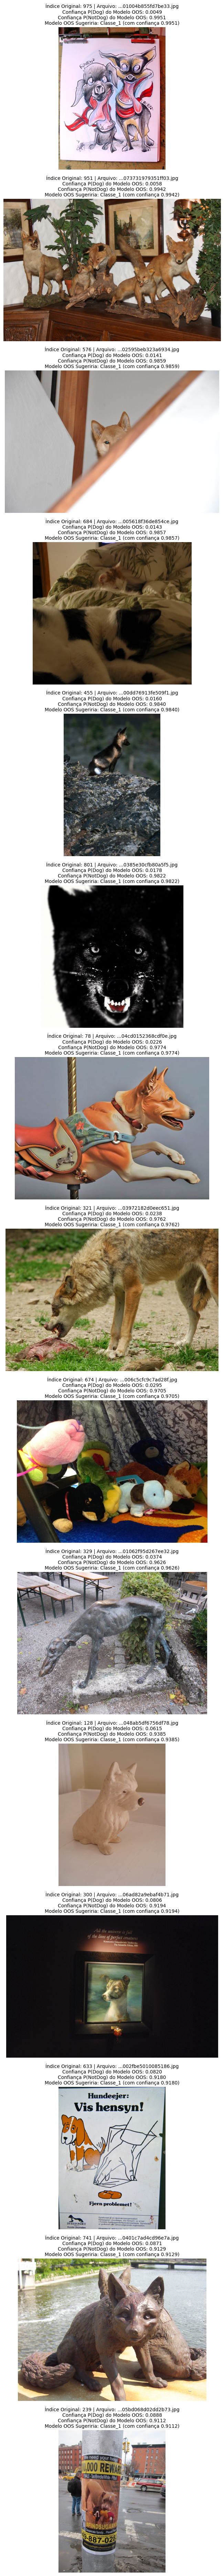

In [11]:
if 'pred_probs_for_dogs_only' not in globals() or pred_probs_for_dogs_only.size == 0:
    print("Variável 'pred_probs_for_dogs_only' não encontrada ou vazia. Execute as etapas anteriores.")
else:
    # Extrai a probabilidade da classe "Dog" para cada imagem de cão
    # Lembre-se: CLASS_LABEL_TO_NUMERIC = {"Dog": 0, "NotDog": 1}
    # Então, a coluna 0 de pred_probs_for_dogs_only é P(Dog)
    prob_dog_class_index = CLASS_LABEL_TO_NUMERIC["Dog"]
    confidence_scores_p_dog = pred_probs_for_dogs_only[:, prob_dog_class_index]

    # Obtém os índices que ordenariam as confianças em ordem ascendente (menor confiança primeiro)
    sorted_indices_by_lowest_confidence = np.argsort(confidence_scores_p_dog)

    num_to_visualize = 15

    print(f"Mostrando as {num_to_visualize} imagens de 'Dog' com a menor confiança P(Dog) do modelo OOS:")

    if num_to_visualize > 0 and len(sorted_indices_by_lowest_confidence) > 0 :
        plt.figure(figsize=(20, 5 * num_to_visualize)) # Ajuste o tamanho conforme necessário

        for i, image_idx in enumerate(sorted_indices_by_lowest_confidence[:num_to_visualize]):
            # image_idx é o índice original da imagem na lista actual_dog_files_with_features
            # e em pred_probs_for_dogs_only

            if image_idx < len(actual_dog_files_with_features):
                img_path = actual_dog_files_with_features[image_idx]
                try:
                    img = Image.open(img_path)
                    plt.subplot(num_to_visualize, 1, i + 1)
                    plt.imshow(img)

                    # Probabilidades para esta imagem específica
                    current_probs = pred_probs_for_dogs_only[image_idx]
                    p_dog = current_probs[CLASS_LABEL_TO_NUMERIC["Dog"]]
                    p_not_dog = current_probs[CLASS_LABEL_TO_NUMERIC["NotDog"]]

                    # Classe predita pelo modelo OOS com maior probabilidade
                    predicted_oos_class_numeric = np.argmax(current_probs)
                    predicted_oos_class_label = NUMERIC_TO_CLASS_LABEL.get(predicted_oos_class_numeric, f"Classe_{predicted_oos_class_numeric}")

                    title = (
                        f"Índice Original: {image_idx} | Arquivo: ...{os.path.basename(img_path)}\n"
                        f"Confiança P(Dog) do Modelo OOS: {p_dog:.4f}\n"
                        f"Confiança P(NotDog) do Modelo OOS: {p_not_dog:.4f}\n"
                        f"Modelo OOS Sugeriria: {predicted_oos_class_label} (com confiança {current_probs[predicted_oos_class_numeric]:.4f})"
                    )
                    plt.title(title, fontsize=10)
                    plt.axis('off')
                except FileNotFoundError:
                    print(f"Arquivo de imagem não encontrado: {img_path}")
                except Exception as e_display:
                    print(f"Erro ao exibir imagem {img_path}: {e_display}")
            else:
                print(f"Índice {image_idx} fora dos limites da lista de arquivos de cães.")

        plt.tight_layout()
        plt.show()
    else:
        print("Nenhuma imagem para visualizar.")

### Aplicando o cleanlab

In [16]:
if 'features_X_dogs' in globals() and features_X_dogs.ndim == 2 and features_X_dogs.shape[0] > 0:

    # Criar um DataFrame para o Datalab
    if len(actual_dog_files_with_features) == features_X_dogs.shape[0]:
        df_dogs_for_datalab = pd.DataFrame({'filepath': actual_dog_files_with_features})
    else:
        # Se os tamanhos não baterem, apenas crie um DataFrame com um índice padrão.
        # Isso pode acontecer se a extração de features falhou para alguns arquivos.
        print(f"Aviso: O número de filepaths ({len(actual_dog_files_with_features)}) não corresponde ao número de features ({features_X_dogs.shape[0]}). Usando índice numérico para Datalab.")
        df_dogs_for_datalab = pd.DataFrame(index=range(features_X_dogs.shape[0]))

    try:
        # Inicializa o Datalab.
        lab_dogs_data_quality = Datalab(data=df_dogs_for_datalab)

        # Encontrar apenas outliers e near-duplicates usando as features dos cães
        lab_dogs_data_quality.find_issues(
            features=features_X_dogs, # Array NumPy das features de distância, similaridade, etc.
            issue_types={"outlier": {}, "near_duplicate": {}}
        )

        print("\nRelatório do Datalab para Outliers e Near-Duplicates:")
        lab_dogs_data_quality.report()

        if 'is_outlier_issue' in lab_dogs_data_quality.issues.columns:
            outlier_issues_df = lab_dogs_data_quality.get_issues("outlier")
            identified_outliers = outlier_issues_df[outlier_issues_df['is_outlier_issue'] == True]
            print(f"\nTotal de Outliers identificados: {len(identified_outliers)}")
            if not identified_outliers.empty:
                print("Exemplos de Outliers:")
                print(identified_outliers.head())
        else:
            print("\nColuna 'is_outlier_issue' não encontrada no sumário de issues.")

        if 'is_near_duplicate_issue' in lab_dogs_data_quality.issues.columns:
            near_duplicate_issues_df = lab_dogs_data_quality.get_issues("near_duplicate")
            identified_near_duplicates = near_duplicate_issues_df[near_duplicate_issues_df['is_near_duplicate_issue'] == True]
            print(f"\nTotal de Near-Duplicates identificados: {len(identified_near_duplicates)}")
            if not identified_near_duplicates.empty:
                print("Exemplos de Near-Duplicates:")
                print(identified_near_duplicates.head())
        else:
            print("\nColuna 'is_near_duplicate_issue' não encontrada no sumário de issues.")

    except Exception as e_datalab_data:
        print(f"Erro ao usar Datalab para análise de qualidade de dados: {e_datalab_data}")
else:
    print("Features dos cães (features_X_dogs) não disponíveis ou inválidas para análise de outliers/near-duplicates com Datalab.")

Finding outlier issues ...
Finding near_duplicate issues ...

Audit complete. 0 issues found in the dataset.

Relatório do Datalab para Outliers e Near-Duplicates:
No issues found in the data. Good job!

Try re-running Datalab.report() with `show_summary_score = True` and `show_all_issues = True`.

Total de Outliers identificados: 0

Total de Near-Duplicates identificados: 0


# Conclusão

Ficou evidente que a abordagem de treinar um modelo Out-of-Sample (OOS) para gerar probabilidades de classe, mesmo um modelo simples como LogisticRegression sobre features de ViT, é uma ferramenta excelente para encontrar de erros de rotulagem. Embora as tentativas de utilizar a biblioteca cleanlab com diversos parâmetros não tenham resultado na detecção automática de erros no conjunto de 1000 imagens de 'Cachorro', a inspeção manual das imagens que o modelo OOS classificou com menor confiança nessa categoria expôs instâncias que visualmente não correspondiam à classe, **como exemplos claros de gatos rotulados como cães**.